In [3]:
# Install required packages
!pip install gymnasium -q
!pip install tensorflow -q

In [4]:
# Step 1: Environment Setup

# Import necessary libraries
import gymnasium as gym
import tensorflow as tf

print(f'Gymnasium version: {gym.__version__}')
print(f'TensorFlow version: {tf.__version__}')

Gymnasium version: 1.2.1
TensorFlow version: 2.19.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Synthetic data generation

It produces two outputs:

- traffic_data - a 2-column array of features:

  - Column 1: traffic_flow (how many vehicles per minute)

  - Column 2: waiting_time (average time vehicles wait at red light)

- rewards - random values between 0 and 1 (used just as placeholders for now).

In [5]:
# Step 2: Data Collection
import numpy as np

def generate_traffic_data(num_samples):
    traffic_flow = np.random.randint(50, 300, num_samples)     # vehicles/min
    waiting_time = np.random.uniform(10, 120, num_samples)      # sec
    traffic_data = np.column_stack((traffic_flow, waiting_time))
    rewards = np.random.rand(num_samples)                       # demo only
    return traffic_data, rewards

num_samples = 1000
traffic_data, rewards = generate_traffic_data(num_samples)

print("Sample traffic data:", traffic_data[:5])
print("Sample rewards:", rewards[:5])


Sample traffic data: [[297.         103.28946895]
 [227.         117.59682324]
 [239.          53.47863856]
 [279.         115.42372592]
 [231.          73.76480539]]
Sample rewards: [0.38105268 0.30742962 0.17931526 0.2683307  0.07324999]


## Custom Gym environment

1. Action Space
  - Agent can choose one of 4 possible traffic signal phases. <br>
  For example:
    - 0 ---- Green for North-South
    - 1 ---- Green for East-West
    - 2 ---- Green for Left-turn lanes
    - 3 ---- Green for Pedestrians
2. reset() function
  - Called at the start of each episode (a simulated day or run).It sets the environment back to the beginning .Returns the first observation (initial state).
3. step(action)
  This is the heart of the environment — it simulates one time step.

  Every time the agent picks an action (e.g., turn north–south green),
  this function:

  - Updates the world (queues move, times change),

  - Computes a reward (good or bad),

  - Returns the new state and whether the episode is over.
4. Reward
  A higher reward means better traffic flow. <br>
  Here, since we want less waiting, the reward is negative waiting time.
  - 1 --- The chosen signal improved traffic flow (cars cleared, waiting reduced)
  - -1 --- The chosen signal worsened things (queues built up)

  - 0 --- Neutral or no significant change

5. render() <br>
  visualize the state.


In [17]:
from gym import spaces
import numpy as np

class TrafficSignalControlEnv(gym.Env):
    def __init__(self):
        super(TrafficSignalControlEnv, self).__init__()

        # Define the action space (e.g., traffic signal phase durations)
        self.action_space = spaces.Discrete(4)  # Example: 4 signal phases

        # Define the state space (e.g., traffic data)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(2,),  # Example: traffic flow and waiting time
            dtype=np.float32
        )

        # Define other environment parameters
        self.max_steps = 200
        self.current_step = 0

    def reset(self):
        # Reset the environment, return an initial state
        self.current_step = 0
        initial_state = np.random.rand(2)  # Replace with real initial state
        return initial_state

    def step(self, action):
        # Execute the selected action and return the next state, reward, done flag, and info
        reward = self.calculate_reward(action)  # Calculate reward based on the action
        next_state = np.random.rand(2)  # Replace with real next state
        done = self.current_step >= self.max_steps
        self.current_step += 1
        return next_state, reward, done, {}

    def calculate_reward(self, action):
        # Implement a custom reward function based on the action taken and the current state
        # Example: Reward based on the action (e.g., phase duration)
        if action == 0:
            reward = 0
        elif action == 1:
            reward = 1
        elif action == 2:
            reward = -1
        else:
            reward = 0
        return reward

    def render(self, mode='human'):
        # Optional: Implement a rendering method for visualization
        pass

    def close(self):
        # Optional: Clean up resources, if necessary
        pass

# Create an instance of the custom environment
env = TrafficSignalControlEnv()

# Test the environment by resetting and taking a few steps
initial_state = env.reset()
for _ in range(110):
    action = env.action_space.sample()  # Sample a random action
    next_state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")


Action: 3, Next State: [0.04002137 0.49872789], Reward: 0, Done: False
Action: 0, Next State: [0.88556255 0.3844154 ], Reward: 0, Done: False
Action: 0, Next State: [0.25624792 0.98992328], Reward: 0, Done: False
Action: 3, Next State: [0.18889217 0.95451788], Reward: 0, Done: False
Action: 1, Next State: [0.64988735 0.12737431], Reward: 1, Done: False
Action: 0, Next State: [0.18629612 0.90156496], Reward: 0, Done: False
Action: 0, Next State: [0.96120569 0.69810007], Reward: 0, Done: False
Action: 2, Next State: [0.44165363 0.9636482 ], Reward: -1, Done: False
Action: 0, Next State: [0.75909075 0.47207683], Reward: 0, Done: False
Action: 0, Next State: [0.41901345 0.31155505], Reward: 0, Done: False
Action: 0, Next State: [0.07717127 0.7188094 ], Reward: 0, Done: False
Action: 2, Next State: [0.48529187 0.78066982], Reward: -1, Done: False
Action: 3, Next State: [0.77336643 0.70305274], Reward: 0, Done: False
Action: 2, Next State: [0.79592107 0.30747073], Reward: -1, Done: False
Act

## Deep Q-Network (DQN)

DQN uses two networks:

- The main (online) model predicts current Q-values and gets updated every step.

- The target model holds an older, frozen copy of the weights and computes the target Q-value max_a' Q_target(s', a').

Then, every few episodes, we copy the main model’s weights into the target model:

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()

        # Define the neural network architecture
        self.dense1 = layers.Dense(32, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(num_actions, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Example usage:
# Create an instance of the DQN model
num_actions = 4
model = DQN(num_actions)
target_model = DQN(num_actions)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

## Reinforcement Learning Algorithm

In [19]:
import numpy as np

def deep_q_learning(env, model, num_episodes, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    history = {'episode': [], 'total_reward': []}
    epsilon = epsilon_start

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0

        while True:
            # Choose an action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(np.expand_dims(state, axis=0))
                action = np.argmax(q_values)

            next_state, reward, done, _ = env.step(action)

            # Update the Q-values using the Bellman equation
            target = reward + gamma * np.max(model.predict(np.expand_dims(next_state, axis=0)))
            target = np.where(done, reward, target)

            with tf.GradientTape() as tape:
                q_values = model(np.expand_dims(state, axis=0))
                loss = tf.keras.losses.MSE(target, q_values[0, action])

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            total_reward += reward
            state = next_state

            if done:
                break

        # Decay epsilon to encourage exploitation over time
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Log episode results
        history['episode'].append(episode)
        history['total_reward'].append(total_reward)
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

    return history



## Live ploting

In [23]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np

class LiveRewardsPlot:
    def __init__(self, ma_window=50, title="DQN Training Reward"):
        self.ep = []
        self.rew = []
        self.maw = int(ma_window)
        self.title = title

        self.fig, self.ax = plt.subplots(figsize=(8,4))
        (self.l_total,) = self.ax.plot([], [], label="Total Reward")
        (self.l_ma,)    = self.ax.plot([], [], label=f"Moving Avg ({self.maw})")
        self.ax.set_xlabel("Episode")
        self.ax.set_ylabel("Total Reward")
        self.ax.set_title(self.title)
        self.ax.grid(True)
        self.ax.legend()

    def update(self, episode_idx, total_reward):
        # Append new point
        self.ep.append(int(episode_idx))
        self.rew.append(float(total_reward))

        # --- Update total reward line (always safe) ---
        self.l_total.set_data(self.ep, self.rew)

        # --- Update moving average line (only if enough points) ---
        n = len(self.rew)
        if n >= self.maw:
            # Valid moving average of length n - maw + 1
            kernel = np.ones(self.maw, dtype=float) / self.maw
            ma = np.convolve(np.array(self.rew, dtype=float), kernel, mode='valid')
            ma_x = self.ep[self.maw - 1:]  # align x with the 'valid' output
            # Make sure lengths match
            if len(ma_x) != len(ma):
                # Safety clamp (shouldn't happen, but prevents broadcast errors)
                m = min(len(ma_x), len(ma))
                ma_x = ma_x[:m]
                ma   = ma[:m]
            self.l_ma.set_data(ma_x, ma)
        else:
            # Not enough points yet: plot empty MA to avoid shape mismatch
            self.l_ma.set_data([], [])

        # --- Rescale & redraw ---
        self.ax.relim()
        self.ax.autoscale_view()

        clear_output(wait=True)
        display(self.fig)
        # Small pause gives the front-end a chance to refresh
        plt.pause(0.001)


## Training Loop


=== Episode 1/10 ===
[Ep 001 | Step 0001] Action=1  NextState=[0.229 0.203]  Reward=1.000  TotalReward=1.000  Done=False
[Ep 001 | Step 0002] Action=3  NextState=[0.818 0.35 ]  Reward=0.000  TotalReward=1.000  Done=False
[Ep 001 | Step 0003] Action=0  NextState=[0.239 0.031]  Reward=0.000  TotalReward=1.000  Done=False
[Ep 001 | Step 0004] Action=0  NextState=[0.528 0.35 ]  Reward=0.000  TotalReward=1.000  Done=False
[Ep 001 | Step 0005] Action=1  NextState=[0.671 0.368]  Reward=1.000  TotalReward=2.000  Done=False
[Ep 001 | Step 0006] Action=3  NextState=[0.439 0.668]  Reward=0.000  TotalReward=2.000  Done=False
[Ep 001 | Step 0007] Action=2  NextState=[0.3   0.955]  Reward=-1.000  TotalReward=1.000  Done=False
[Ep 001 | Step 0008] Action=1  NextState=[0.537 0.67 ]  Reward=1.000  TotalReward=2.000  Done=False
[Ep 001 | Step 0009] Action=0  NextState=[0.542 0.066]  Reward=0.000  TotalReward=2.000  Done=False
[Ep 001 | Step 0010] Action=1  NextState=[0.912 0.648]  Reward=1.000  TotalRe

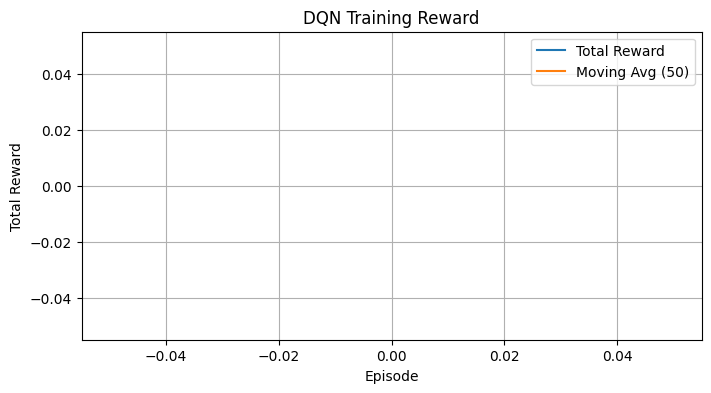

In [29]:
tf.keras.utils.disable_interactive_logging()

# Define hyperparameters
num_episodes = 10 # 1000
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

# Initialize the DQN model
num_actions = 4
model = DQN(num_actions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Initialize the environment
env = TrafficSignalControlEnv()

# Initialize training history for logging
history = {'episode': [], 'total_reward': []}

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epsilon = epsilon_start
best_total_reward = -float('inf')
target_total_reward = 200

plotter = LiveRewardsPlot(ma_window=50, title="DQN Training Reward")

for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0
    step_idx = 0
    done = False


    print(f"\n=== Episode {episode}/{num_episodes} ===")

    while True:
        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(np.expand_dims(state, axis=0),verbose=0)
            action = np.argmax(q_values)

        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        step_idx += 1

        print(f"[Ep {episode:03d} | Step {step_idx:04d}] "
              f"Action={action}  NextState={np.array2string(next_state, precision=3)}  "
              f"Reward={reward:.3f}  TotalReward={total_reward:.3f}  Done={done}")


        # Update the Q-values using the Bellman equation
        target = reward + gamma * np.max(model.predict(np.expand_dims(next_state, axis=0)))
        target = np.where(done, reward, target)

        with tf.GradientTape() as tape:
            q_values = model(np.expand_dims(state, axis=0))
            loss = tf.keras.losses.MeanSquaredError()(target, q_values)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # total_reward += reward
        state = next_state

        if done:
            break

    # Decay epsilon to encourage exploitation over time
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Log episode results
    history['episode'].append(episode)
    history['total_reward'].append(total_reward)
    print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

    # Exit the loop if the target total reward is achieved
    if total_reward >= target_total_reward:
        print(f"Target reward of {target_total_reward} achieved. Exiting training.")
        break

    # Update the best total reward
    if total_reward > best_total_reward:
        best_total_reward = total_reward

    # after episode ends:
    # plotter.update(episode, total_reward)


## Visualization

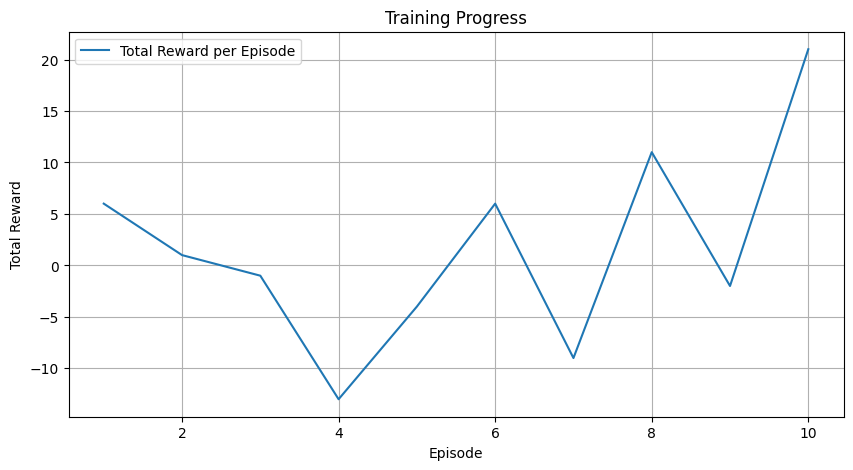

In [30]:

import matplotlib.pyplot as plt

# Plot the total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(history['episode'], history['total_reward'], label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

## Save the model

In [32]:
import tensorflow as tf
import numpy as np

# Determine observation shape from env
obs_shape = env.observation_space.shape  # e.g., (2,) for [flow, wait]
dummy = tf.zeros((1,) + obs_shape, dtype=tf.float32)

# Build both networks by running a no-op forward pass
_ = model(dummy, training=False)
_ = target_model(dummy, training=False)

# Now save
model.save_weights("/content/drive/MyDrive/AARC LAB/RL_models/signal_control/policy.weights.h5")
target_model.save_weights("/content/drive/MyDrive/AARC LAB/RL_models/signal_control/target.weights.h5")
